# MOBPY Example: German Credit Risk Analysis

##### This notebook demonstrates monotonic optimal binning on the German Credit dataset with a binary target variable (default risk).


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import MOBPY components
from MOBPY import MonotonicBinner, BinningConstraints
from MOBPY.plot import (
    plot_bin_statistics, plot_pava_comparison,
    plot_woe_bars, plot_event_rate, plot_sample_distribution,
    plot_bin_boundaries, plot_binning_stability
)

# Set random seed for reproducibility
np.random.seed(42)

##### 1. Load and Prepare Data

In [2]:
# Load the German Credit dataset
df = pd.read_csv('/Users/chentahung/Desktop/git/mob-py/data/german_data_credit_cat.csv')

# Convert default to 0/1 (original is 1/2)
df['default'] = df['default'] - 1

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['default'].value_counts())
print(f"\nDefault rate: {df['default'].mean():.2%}")

Dataset shape: (1000, 21)

Target distribution:
default
0    700
1    300
Name: count, dtype: int64

Default rate: 30.00%


In [3]:
# Display basic information about the dataset
print("Dataset columns:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset columns:
['Statusofexistingcheckingaccount', 'Durationinmonth', 'Credithistory', 'Purpose', 'Creditamount', 'Savingsaccountbonds', 'Presentemploymentsince', 'Installmentrate', 'Personalstatussex', 'Otherdebtors', 'Presentresidence', 'Property', 'Age', 'installmentplans', 'Housing', 'existingcredits', 'Job', 'Numberofpeople', 'Telephone', 'foreignworker', 'default']

First few rows:


,Statusofexistingcheckingaccount,Durationinmonth,Credithistory,Purpose,Creditamount,Savingsaccountbonds,Presentemploymentsince,Installmentrate,Personalstatussex,Otherdebtors,...,Property,Age,installmentplans,Housing,existingcredits,Job,Numberofpeople,Telephone,foreignworker,default
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1


##### 2. Feature Selection and Exploration
Let's select a few numeric features to demonstrate binning:

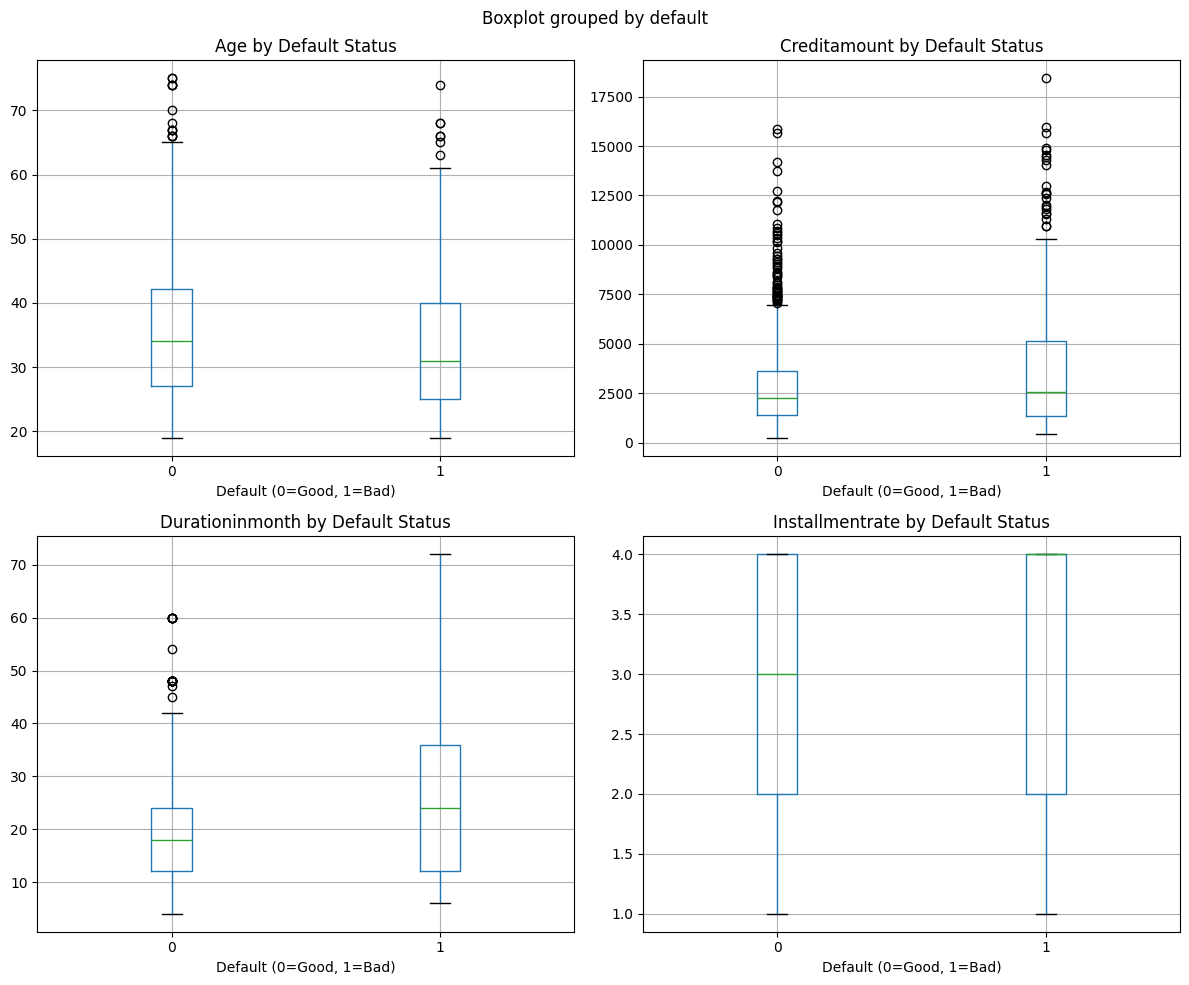

In [4]:
# Select numeric features for binning
numeric_features = ['Age', 'Creditamount', 'Durationinmonth', 'Installmentrate']

# Create visualizations for each feature vs default
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, feature in enumerate(numeric_features):
    ax = axes[idx]
    
    # Box plot by default status
    df.boxplot(column=feature, by='default', ax=ax)
    ax.set_title(f'{feature} by Default Status')
    ax.set_xlabel('Default (0=Good, 1=Bad)')
    
plt.tight_layout()
plt.show()

##### 3. Monotonic Binning Example: Age
Let's start with the Age feature to demonstrate all binning capabilities:

In [5]:
# Define binning constraints
constraints = BinningConstraints(
    max_bins=6,              # Maximum 6 bins
    min_bins=3,              # Minimum 3 bins
    min_samples=0.05,        # Each bin needs at least 5% of data
    min_positives=0.01,      # Each bin needs at least 1% of defaults
    initial_pvalue=0.4,      # P-value threshold for merging
    maximize_bins=False      # Prefer fewer bins if statistically justified
)

# Create and fit the binner
age_binner = MonotonicBinner(
    df=df,
    x='Age',
    y='default',
    constraints=constraints,
    sign='auto',  # Automatically determine monotonicity direction
    strict=True   # Enforce strict monotonicity
)

age_binner.fit()
print(f"Monotonicity direction: {age_binner.resolved_sign_}")

2025-08-16 02:01:11 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 1 bins (reached min_bins=3 limit)
Monotonicity direction: -


##### 3.1 Understanding the PAVA Process

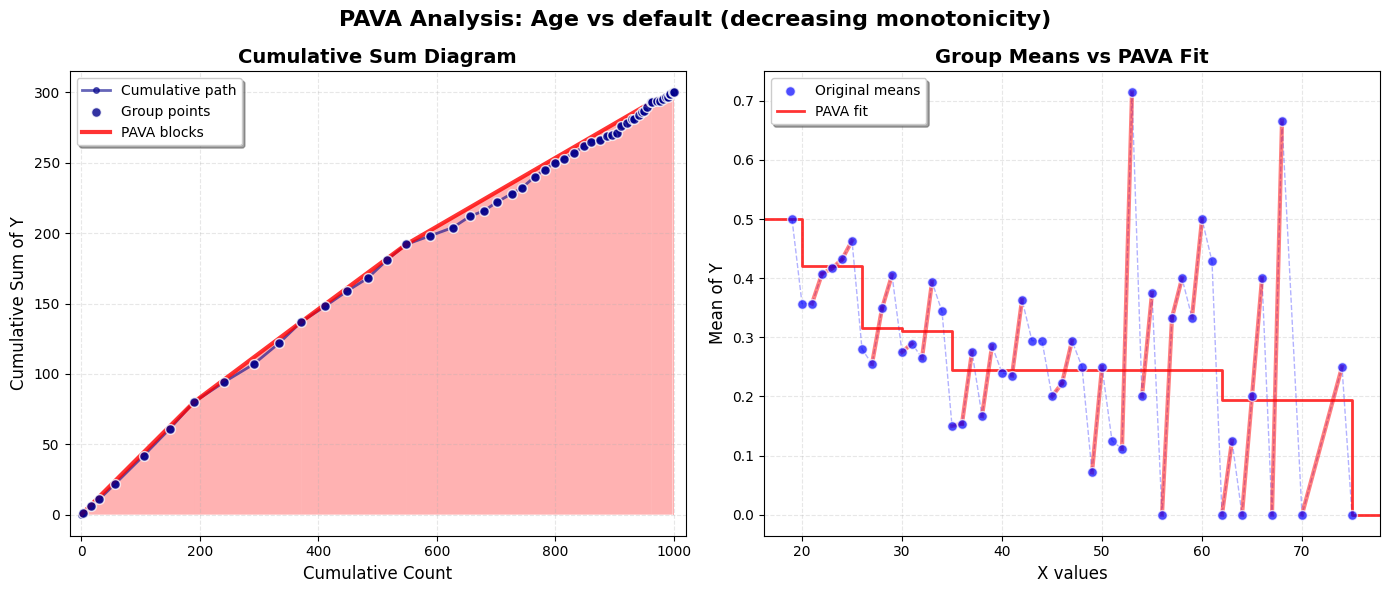


PAVA Diagnostics:
Initial groups: 53
Final blocks: 7
Compression ratio: 7.57


In [6]:
# Visualize how PAVA creates monotonic blocks
fig = plot_pava_comparison(age_binner, figsize=(14, 6))
plt.show()

# Get PAVA diagnostics
pava_diag = age_binner._pava.get_diagnostics()
print(f"\nPAVA Diagnostics:")
print(f"Initial groups: {pava_diag['n_initial_groups']}")
print(f"Final blocks: {pava_diag['n_final_blocks']}")
print(f"Compression ratio: {pava_diag['compression_ratio']:.2f}")

##### 3.2 Binning Results and WoE Analysis

In [7]:
# Get binning summary
summary = age_binner.summary_()
print("\nBinning Summary:")
print(summary)

# Calculate total Information Value
total_iv = summary['iv'].sum()
print(f"\nTotal Information Value: {total_iv:.4f}")


Binning Summary:
       bucket  count  count_pct    sum      mean       std  min  max  \
0  (-inf, 26)    190       19.0   80.0  0.421053  0.495032  0.0  1.0   
1    [26, 35)    358       35.8  112.0  0.312849  0.464302  0.0  1.0   
2  [35, +inf)    452       45.2  108.0  0.238938  0.426907  0.0  1.0   

        woe        iv  
0 -0.527693  0.057771  
1 -0.060042  0.001306  
2  0.310893  0.040796  

Total Information Value: 0.0999


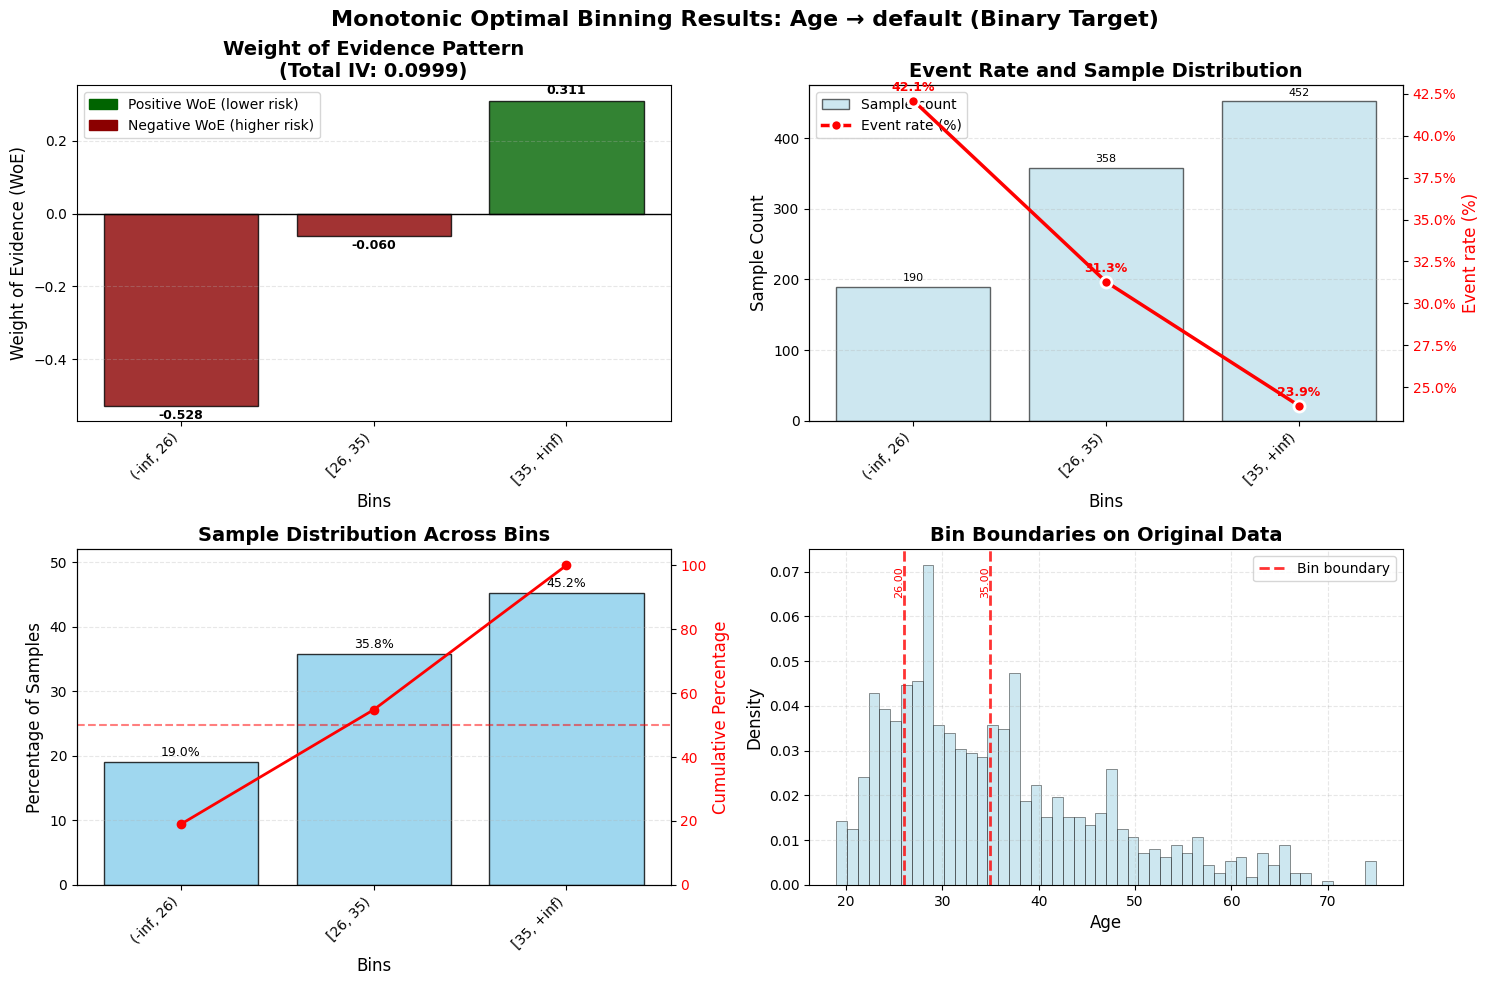

In [8]:
# Comprehensive binning visualization
fig = plot_bin_statistics(age_binner, figsize=(15, 10))
plt.show()

##### 3.3 Individual Plot Components

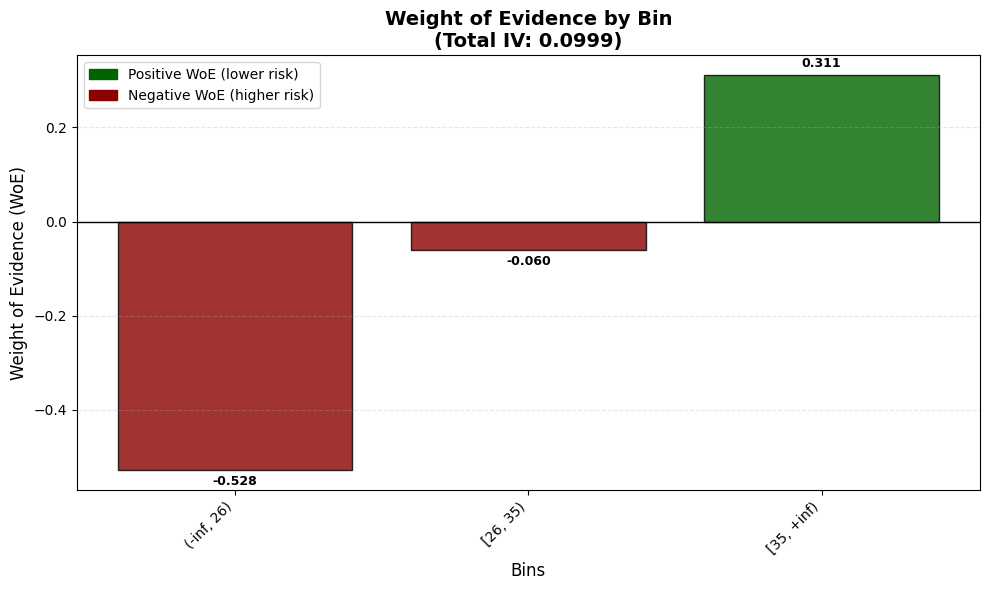

In [9]:
# Weight of Evidence pattern
fig, ax = plt.subplots(figsize=(10, 6))
plot_woe_bars(summary, ax=ax, show_iv=True, show_values=True)
plt.tight_layout()
plt.show()

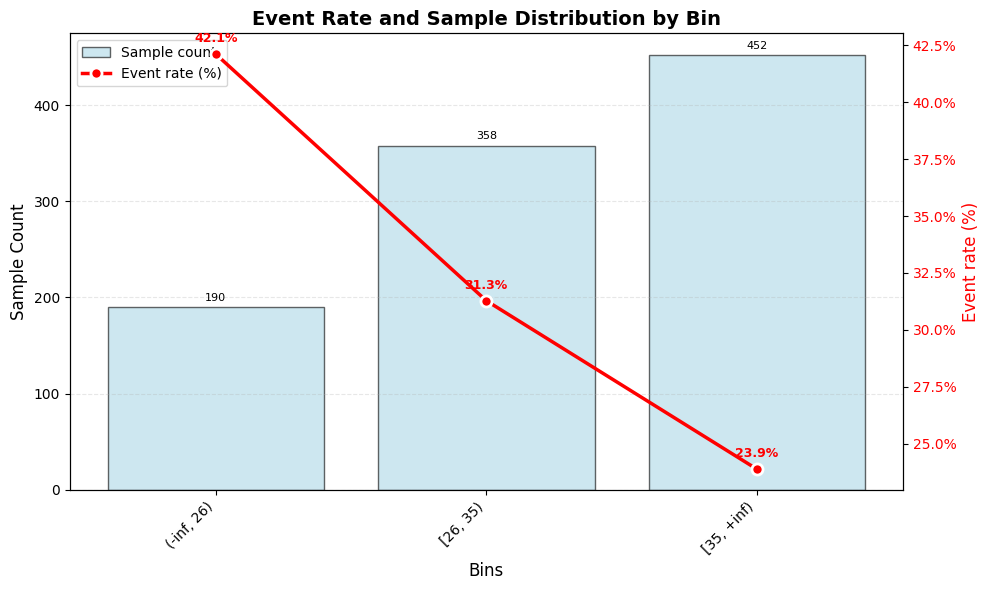

In [10]:
# Event rate and sample distribution
fig, ax = plt.subplots(figsize=(10, 6))
plot_event_rate(summary, ax=ax, show_counts=True, y_format='percentage')
plt.tight_layout()
plt.show()

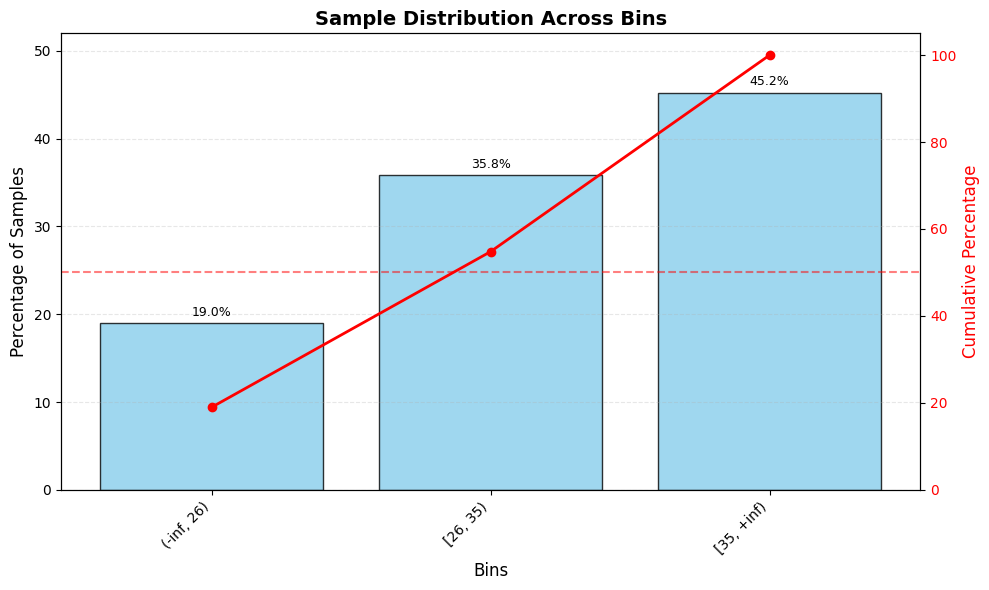

In [11]:
# Sample distribution across bins
fig, ax = plt.subplots(figsize=(10, 6))
plot_sample_distribution(summary, ax=ax, show_cumulative=True)
plt.tight_layout()
plt.show()

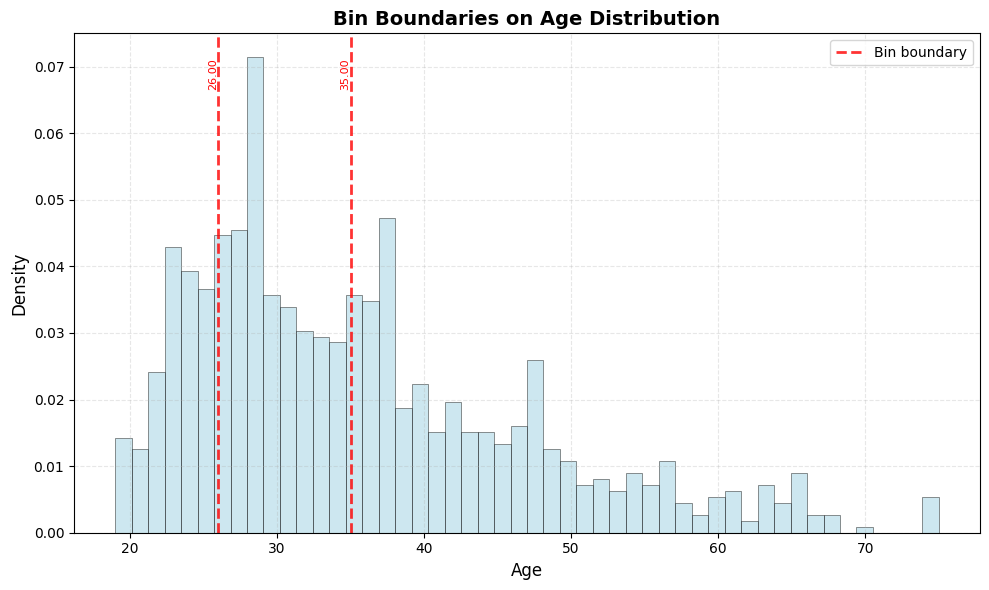

In [12]:
# Bin boundaries on original data
fig, ax = plt.subplots(figsize=(10, 6))
plot_bin_boundaries(age_binner, ax=ax, show_density=True, show_boundaries=True)
plt.tight_layout()
plt.show()

##### 4. Comparing Different Constraint Settings
Let's see how different constraints affect the binning:

2025-08-16 02:01:12 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 2 bins (reached min_bins=4 limit)


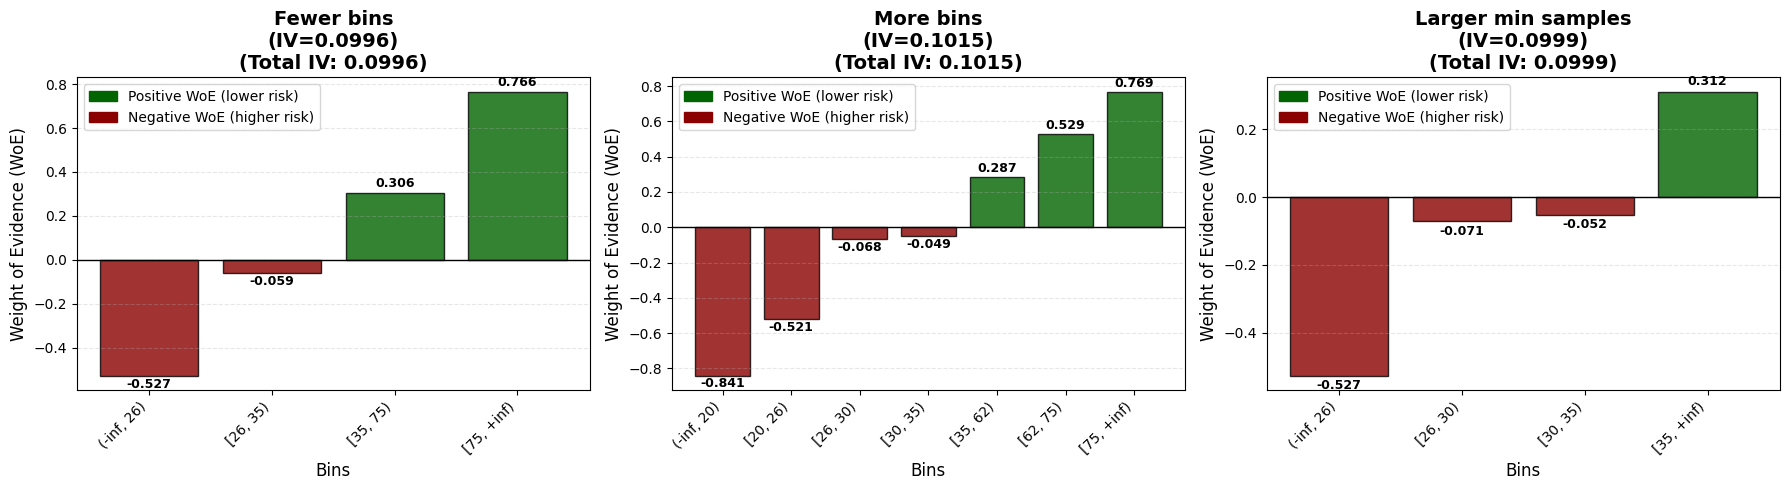

In [13]:
# Compare different constraint settings
constraint_sets = [
    {'name': 'Fewer bins', 'max_bins': 4, 'min_bins': 2},
    {'name': 'More bins', 'max_bins': 8, 'min_bins': 5},
    {'name': 'Larger min samples', 'max_bins': 6, 'min_samples': 0.10}
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, const_dict in enumerate(constraint_sets):
    # Create constraints
    name = const_dict.pop('name')
    const = BinningConstraints(**const_dict)
    
    # Fit binner
    binner = MonotonicBinner(df=df, x='Age', y='default', constraints=const)
    binner.fit()
    
    # Plot WoE
    summary = binner.summary_()
    plot_woe_bars(summary, ax=axes[idx], title=f'{name}\n(IV={summary["iv"].sum():.4f})')

plt.tight_layout()
plt.show()

##### 5. Binning Multiple Features

2025-08-16 02:01:12 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 2 bins (reached min_bins=4 limit)
2025-08-16 02:01:12 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 3 bins (reached min_bins=4 limit)
2025-08-16 02:01:12 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 2 bins (reached min_bins=4 limit)


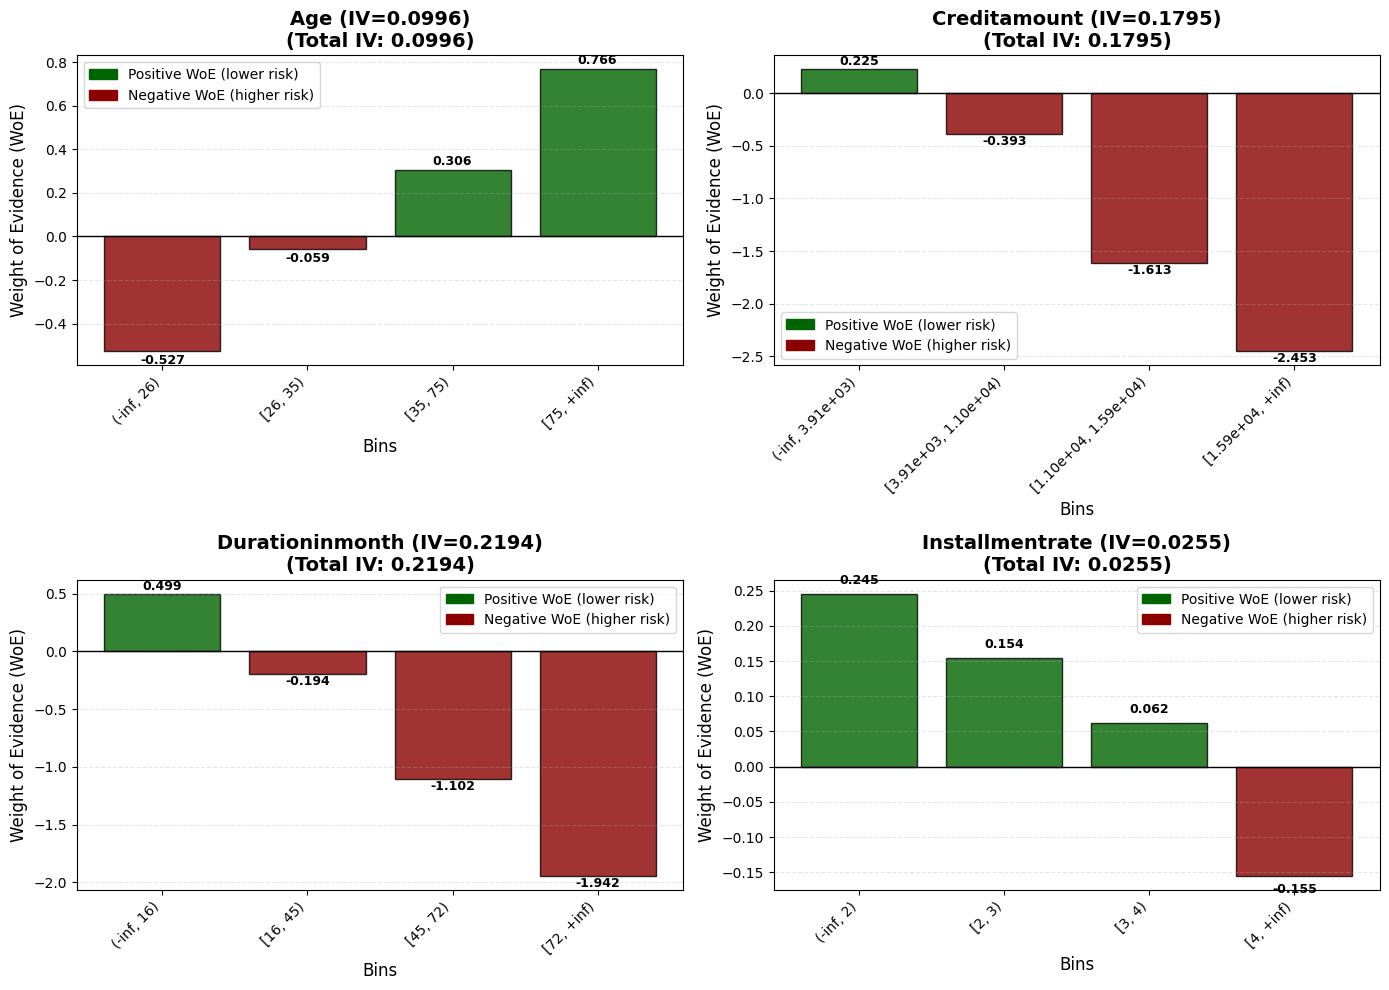


Information Value Comparison:
           Feature        IV Direction
2  Durationinmonth  0.219354         +
1     Creditamount  0.179510         +
0              Age  0.099577         -
3  Installmentrate  0.025473         +


In [14]:
# Bin all numeric features and compare their IVs
iv_results = []

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(numeric_features):
    # Fit binner
    binner = MonotonicBinner(
        df=df,
        x=feature,
        y='default',
        constraints=BinningConstraints(max_bins=5, min_samples=0.05)
    )
    binner.fit()
    
    # Get summary and IV
    summary = binner.summary_()
    total_iv = summary['iv'].sum()
    iv_results.append({'Feature': feature, 'IV': total_iv, 'Direction': binner.resolved_sign_})
    
    # Plot WoE
    plot_woe_bars(summary, ax=axes[idx], title=f'{feature} (IV={total_iv:.4f})')

plt.tight_layout()
plt.show()

# Display IV comparison
iv_df = pd.DataFrame(iv_results).sort_values('IV', ascending=False)
print("\nInformation Value Comparison:")
print(iv_df)

##### 6. Model Stability: Train/Test Split

In [15]:
# Split data for stability analysis
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['default'])
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

# Fit on training data
stability_binner = MonotonicBinner(
    df=train_df,
    x='Age',
    y='default',
    constraints=BinningConstraints(max_bins=5, min_samples=0.05)
)
stability_binner.fit()

# Check stability on test data
fig = plot_binning_stability(stability_binner, test_df, figsize=(12, 5))
plt.show()

ModuleNotFoundError: No module named 'sklearn'

##### 7. Applying Binning for Scoring

In [ ]:
# Transform features for model use
# Get WoE values for Age
train_df['Age_WoE'] = stability_binner.transform(train_df['Age'], assign='woe')
test_df['Age_WoE'] = stability_binner.transform(test_df['Age'], assign='woe')

print("Original Age vs WoE transformation (first 10 rows):")
print(pd.DataFrame({
    'Age': train_df['Age'].head(10),
    'Age_Bin': stability_binner.transform(train_df['Age'], assign='interval').head(10),
    'Age_WoE': train_df['Age_WoE'].head(10)
}))

##### 8. Advanced: Custom Merge Strategy

In [ ]:
# Compare different merge strategies
strategies = ['highest_pvalue', 'smallest_loss', 'balanced_size']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, strategy in enumerate(strategies):
    binner = MonotonicBinner(
        df=df,
        x='Creditamount',
        y='default',
        constraints=BinningConstraints(max_bins=5, min_samples=0.05),
        merge_strategy=strategy
    )
    binner.fit()
    
    summary = binner.summary_()
    plot_woe_bars(
        summary, 
        ax=axes[idx], 
        title=f'Strategy: {strategy}\n(IV={summary["iv"].sum():.4f}, Bins={len(summary)})'
    )

plt.tight_layout()
plt.show()

##### 9. Handling Special Values

In [ ]:
# Create a feature with special values
df_special = df.copy()
df_special.loc[df_special.index[:50], 'Age'] = -999  # Special code for missing

# Bin with exclusion
special_binner = MonotonicBinner(
    df=df_special,
    x='Age',
    y='default',
    constraints=BinningConstraints(max_bins=5),
    exclude_values=[-999]  # Exclude special values
)
special_binner.fit()

# Check summary - note the "Excluded:-999" row
special_summary = special_binner.summary_()
print("Summary with excluded values:")
print(special_summary)

##### 10. Key Insights and Best Practices

In [ ]:
# Get comprehensive diagnostics
diag = age_binner.get_diagnostics()
print("Binning Diagnostics:")
for key, value in diag.items():
    print(f"  {key}: {value}")